In [133]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math

Read in the data, here dataset was splitted into 3 parts, training dataset, test dataset, and validation dataset.

In [134]:
# read in data
f = open('train.csv', 'rb')
reader = csv.reader(f)

Y = np.empty([42000], dtype = np.int8)
X = np.empty([42000, 784])

rowNum = 0
for row in reader:
    if rowNum == 0: # skip header
        rowNum += 1
    else:
        Y[rowNum - 1] = row[0] # read label
        for col in range(1, 785):
            X[rowNum - 1, col - 1] = row[col] # read image, for each image pixels are put into a row
        rowNum += 1
print 'X shape', X.shape
print 'Y shape', Y.shape

X shape (42000, 784)
Y shape (42000,)


Split data into three parts, training set, val set, and test set

In [135]:
num_train = int((X.shape[0]) * 0.64)
num_val = int((X.shape[0] * 0.16))
num_test = X.shape[0] - num_train - num_val

Y_train = Y[0 : num_train]
Y_val = Y[num_train : num_train + num_val]
Y_test = Y[num_train + num_val : X.shape[0]]

X_train = X[0 : num_train, :]
X_val = X[num_train : (num_train + num_val), :]
X_test = X[(num_train + num_val) : X.shape[0], :]

print 'Y_train shape', Y_train.shape
print 'Y_val shape', Y_val.shape
print 'Y_test shape', Y_test.shape
print 'X_train shape', X_train.shape
print 'X_val shape', X_val.shape
print 'X_test shape', X_test.shape

Y_train shape (26880,)
Y_val shape (6720,)
Y_test shape (8400,)
X_train shape (26880, 784)
X_val shape (6720, 784)
X_test shape (8400, 784)


Here we are using ReLU function as the non-linear function. The net only has one hidder layer, and the hidder layer size is the same as input layer (784). So, the network looks like this: input layer -> hidden layer -> ReLU -> output layer. This network configuration is the same as the scikit-learn version neural network.

In [136]:
input_size = 784
hidden_size = 784
output_size = 10
W1 = 1e-4 * np.random.randn(input_size, hidden_size) # initialize and randomize the parameters
b1 = np.zeros(hidden_size)
W2 = 1e-4 * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

In [137]:
num_itrs = 4000 # # of iterations, this will be broken by convergence check
batch_size = 200 # batch size
reg = 0.5 # regularization parameter
learning_rate = 1e-3 # learning rate, here we are using the constant learning rate, which is the same as scikit-lean version code
iterations_per_epoch = int(num_train / batch_size) # each epoch has iterations_per_epoch iterations
epoch = 0
loss_history = []
train_acc_history = []
val_acc_history = []
print 'iterations_per_epoch', iterations_per_epoch

iterations_per_epoch 134


In [138]:
def predict(X, Y, W1, b1, W2, b2): # predict the accuracy
    h1 = X.dot(W1) + b1
    r1 = np.maximum(0, h1)
    scores = r1.dot(W2) + b2
    y_pred = np.argmax(scores, axis = 1)
    
    return y_pred

In [139]:
for itr in range(num_itrs):
    random_index = np.random.choice(np.arange(num_train), batch_size)
    X_batch = X_train[random_index]
    Y_batch = Y_train[random_index].astype(dtype = np.int8)
    
    # Compute the scores
    h1 = X_batch.dot(W1) + b1
    r1 = np.maximum(0, h1) # ReLU function
    scores = r1.dot(W2) + b2
    
    # compute the loss using L2 regularization and softmax
    scores = np.exp(scores)
    probs = scores / np.sum(scores, axis = 1, keepdims = True)
    index = np.arange(X_batch.shape[0], dtype = np.int8)
    target_probs = probs[index, Y_batch]
    log_probs = -np.log(target_probs)
    data_loss = np.sum(log_probs) / X_batch.shape[0]
    loss = data_loss + 0.5 * reg * np.sum(np.square(W1)) + 0.5 * reg * np.sum(np.square(W2))
    
    # backward propagation
    grads = {}
    # softmax derivative
    dscores = probs
    dscores[np.arange(X_batch.shape[0]), Y_batch] -= 1
    dscores /= X_batch.shape[0]
    
    # backward propagate
    grads['W2'] = r1.T.dot(dscores)
    grads['b2'] = np.sum(dscores, axis = 0)
    
    dh = dscores.dot(W2.T)
    dh[h1 <= 0] = 0
    
    grads['W1'] = X_batch.T.dot(dh)
    grads['b1'] = np.sum(dh, axis = 0)
    
    grads['W2'] += reg * W2
    grads['W1'] += reg * W1
        
    W1 -= learning_rate * grads['W1']
    b1 -= learning_rate * grads['b1']
    W2 -= learning_rate * grads['W2']
    b2 -= learning_rate * grads['b2']
    
    # Every epoch, check train and val accuracy
    if itr % iterations_per_epoch == 0:
        
        loss_history.append(loss)
        
        # check accuracy
        train_acc = (predict(X_batch, Y_batch, W1, b1, W2, b2) == Y_batch).mean()
        val_acc = (predict(X_val, Y_val, W1, b1, W2, b2) == Y_val).mean()
        train_acc_history.append(train_acc)  
        
        if len(val_acc_history) != 0 and math.fabs(val_acc - val_acc_history[-1]) <= 1e-4: # convergence detection
            val_acc_history.append(val_acc)
            print 'epoch %d: train_acc: %f, val_acc: %f' % (epoch, train_acc, val_acc)
            print 'train is done!'
            break
        
        val_acc_history.append(val_acc)
        print 'epoch %d: train_acc: %f, val_acc: %f' % (epoch, train_acc, val_acc)
        epoch += 1

epoch 0: train_acc: 0.385000, val_acc: 0.288839
epoch 1: train_acc: 0.890000, val_acc: 0.874256
epoch 2: train_acc: 0.905000, val_acc: 0.898065
epoch 3: train_acc: 0.930000, val_acc: 0.906548
epoch 4: train_acc: 0.960000, val_acc: 0.923661
epoch 5: train_acc: 0.935000, val_acc: 0.929464
epoch 6: train_acc: 0.935000, val_acc: 0.936607
epoch 7: train_acc: 0.935000, val_acc: 0.941071
epoch 8: train_acc: 0.955000, val_acc: 0.945685
epoch 9: train_acc: 0.940000, val_acc: 0.945387
epoch 10: train_acc: 0.980000, val_acc: 0.948065
epoch 11: train_acc: 0.975000, val_acc: 0.952083
epoch 12: train_acc: 0.965000, val_acc: 0.946131
epoch 13: train_acc: 0.985000, val_acc: 0.954167
epoch 14: train_acc: 0.965000, val_acc: 0.955952
epoch 15: train_acc: 0.980000, val_acc: 0.957589
epoch 16: train_acc: 0.975000, val_acc: 0.957738
epoch 17: train_acc: 0.990000, val_acc: 0.958185
epoch 18: train_acc: 0.975000, val_acc: 0.957440
epoch 19: train_acc: 0.980000, val_acc: 0.956994
epoch 20: train_acc: 0.955000,

Plot the loss, validation accuracy, and training accuracy

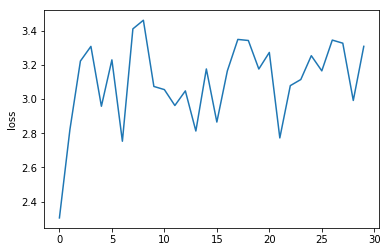

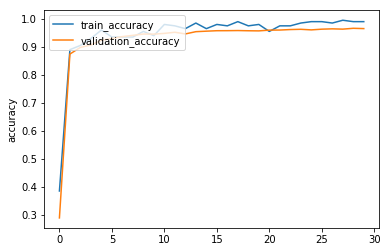

In [143]:
plt.figure()
plt.plot(loss_history)
plt.ylabel('loss')

plt.figure()
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.ylabel('accuracy')
plt.legend(['train_accuracy', 'validation_accuracy'], loc = 'upper left')

plt.show()

Test the neural nework using test dataset

In [141]:
test_acc = (predict(X_test, Y_test, W1, b1, W2, b2) == Y_test).mean()
print 'test accuracy: %f' % (test_acc)

test accuracy: 0.965952
